In [40]:
import fastai
from matplotlib import pyplot as plt

In [6]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# import pytorch

In [7]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [8]:
PATH = "data/dogscats/"
sz=224

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.backends.cudnn.enabled

True

In [11]:
!pwd

/content/clouderizer/catsvsdogs/code


In [52]:
# !ln -s /content/clouderizer/catsvsdogs/data/train {PATH}
# !ln -s /content/clouderizer/catsvsdogs/data/test {PATH}
# !ln -s /content/clouderizer/catsvsdogs/data/valid {PATH}

In [16]:
!pip install kaggle

torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [17]:
import kaggle

In [54]:
!wget http://files.fast.ai/data/dogscats.zip

--2018-06-20 02:44:32--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M   107MB/s    in 7.8s    

2018-06-20 02:44:40 (105 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [21]:
!ln -s '../data/' ./
!ln -s '../out/' ./

In [55]:
!pwd

/content/clouderizer/catsvsdogs/data/competitions/dogs-vs-cats


In [74]:
%cd ..  

/content/clouderizer/catsvsdogs/data/competitions/dogs-vs-cats/dogscats


In [75]:
! ls

models	sample	test1  train  valid


In [77]:
PATH='/content/clouderizer/catsvsdogs/data/competitions/dogs-vs-cats/dogscats/'

In [78]:
# !unzip dogscats.zip

In [80]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.8175.jpg',
 'cat.8072.jpg',
 'cat.4643.jpg',
 'cat.11537.jpg',
 'cat.7728.jpg']

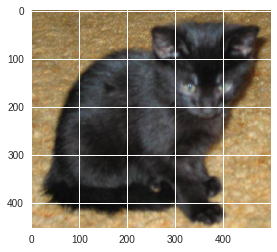

In [83]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [42]:
img.shape

(412, 431, 3)

In [43]:
# # We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. 
# Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet 
# (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), 
# a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs 
# during this course.

# # We will be using the resnet34 model. resnet34 is a version of the model that won the 2015 ImageNet competition. 
# Here is more info on resnet models. We'll be studying them in depth later, but for now we'll focus on using them effectively.

# Here's how to train and evalulate a dogs vs cats model in 3 lines of code, and under 20 seconds:

In [85]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.051676   0.029159   0.9895    
    1      0.047276   0.026102   0.99                         



[array([0.0261]), 0.99]

In [91]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [87]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [89]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [92]:
log_preds[:10]

array([[ -0.00134,  -6.61721],
       [ -0.00271,  -5.91153],
       [ -0.00071,  -7.24408],
       [ -0.00007,  -9.56567],
       [ -0.00283,  -5.86812],
       [ -0.00034,  -7.99867],
       [ -0.00142,  -6.55982],
       [ -0.     , -12.76696],
       [ -0.00004, -10.10977],
       [ -0.00127,  -6.67194]], dtype=float32)

In [94]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [105]:
probs = np.exp(log_preds[:,1])        # pr(dog)
probs[:10]

0.002708039

In [102]:
# data.val_ds

In [96]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [97]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [98]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [99]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [104]:
rand_by_correct(True)

array([ 109, 1582, 1557, 1356])

Correctly classified


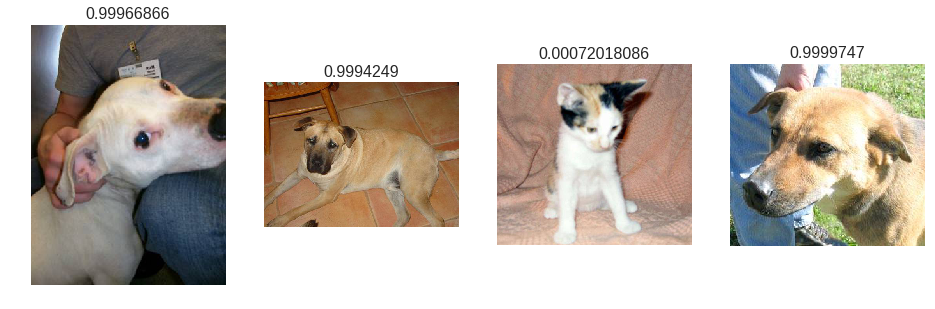

In [103]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


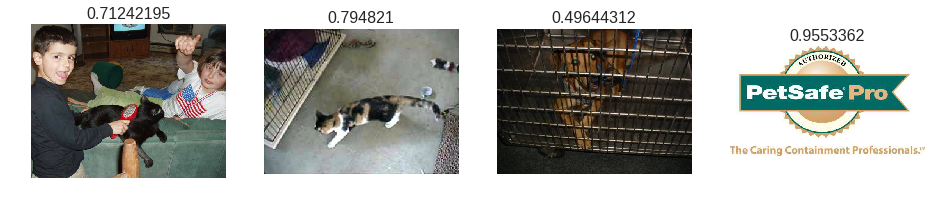

In [106]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [107]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


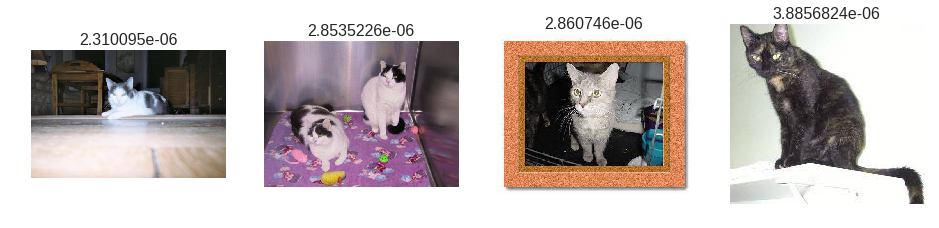

In [108]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


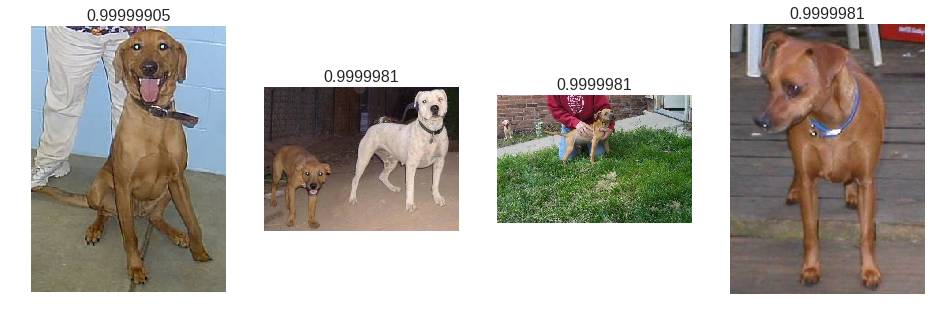

In [109]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


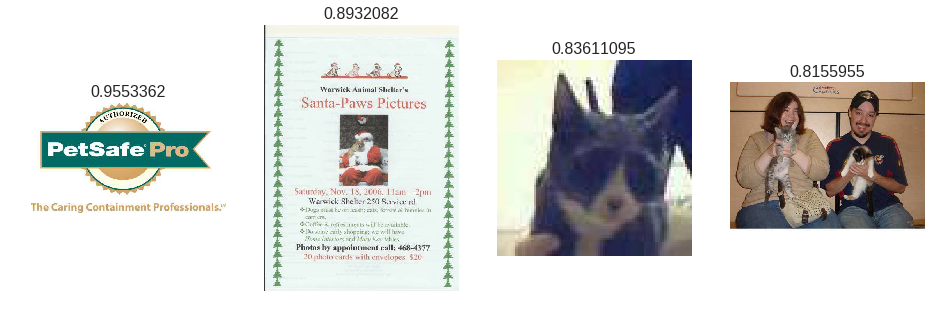

In [110]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


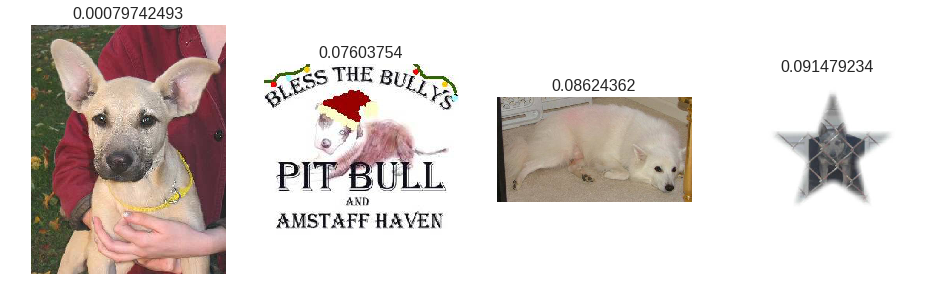

In [111]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


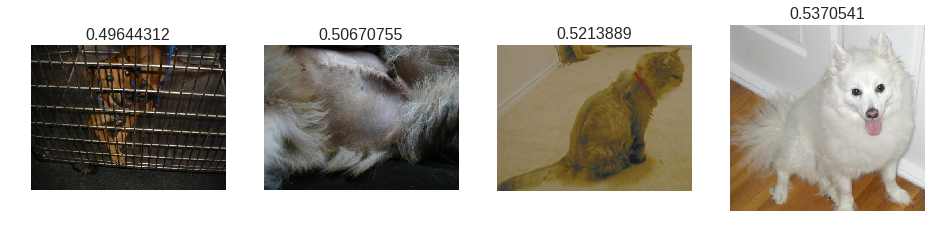

In [112]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

# Choosing a learning rate

In [114]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [115]:
lrf=learn.lr_find()

 82%|████████▏ | 294/360 [00:07<00:01, 37.31it/s, loss=0.476]


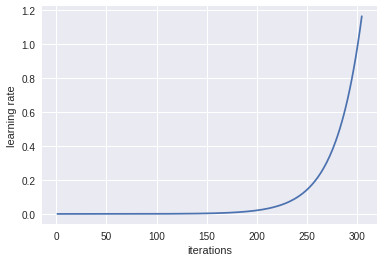

In [116]:
learn.sched.plot_lr()

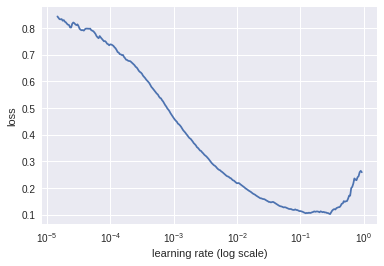

In [117]:
learn.sched.plot()

In [118]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [119]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [120]:
ims = np.stack([get_augs() for i in range(6)])

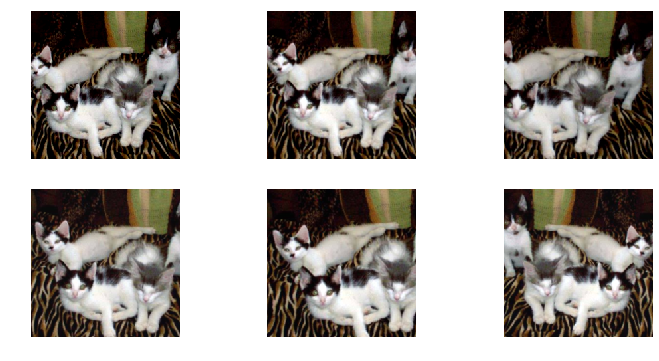

In [121]:
plots(ims, rows=2)

In [122]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [123]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.055547   0.030403   0.991     



[array([0.0304]), 0.991]

In [124]:
learn.precompute=False

In [125]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.044186   0.026507   0.992     
    1      0.051798   0.026362   0.9915                       
    2      0.049789   0.028451   0.9895                       



[array([0.02845]), 0.9895]

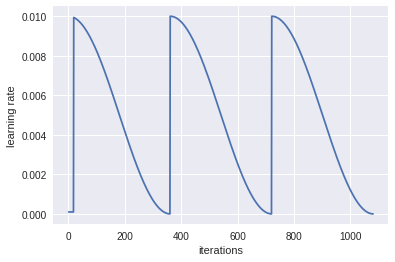

In [126]:
learn.sched.plot_lr()

In [127]:
learn.save('224_lastlayer')

In [128]:
learn.load('224_lastlayer')

# Fine-tuning and differential learning rate annealing

In [130]:
learn.unfreeze()

In [131]:
lr=np.array([1e-4,1e-3,1e-2])

In [132]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048943   0.02684    0.99      
    1      0.033399   0.024099   0.9905                       
    2      0.030995   0.023941   0.989                        
    3      0.040984   0.023084   0.992                        
    4      0.028141   0.020793   0.993                        
    5      0.02483    0.018787   0.993                        
    6      0.021654   0.019062   0.993                        



[array([0.01906]), 0.993]

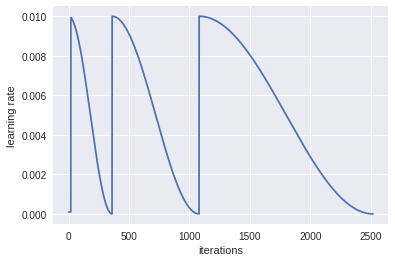

In [133]:
learn.sched.plot_lr()

In [134]:
learn.save('224_all')

In [135]:
learn.load('224_all')

In [136]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [137]:
accuracy_np(probs, y)

0.9925

In [138]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [139]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[992   8]
 [  7 993]]


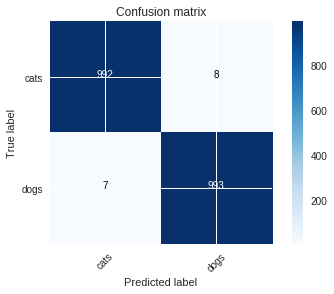

In [140]:
plot_confusion_matrix(cm, data.classes)